# Úloha zjištění sentimentu z textu

## Dataset IMDB

Jedná se o datovou sadu 25 000 recenzí filmů z IMDB, označených podle sentimentu (pozitivní/negativní). 

Recenze byly předem zpracovány a každá recenze je zakódována jako seznam slovních indexů (celých čísel). 

Pro větší pohodlí jsou slova indexována podle celkové četnosti v souboru dat, takže například celé číslo "3" kóduje třetí nejčastější slovo v datech. 

To umožňuje rychlé operace filtrování, jako např: "zohlednit pouze 10 000 nejčastějších slov, ale vyřadit 20 nejčastějších slov".

Podle konvence "0" neoznačuje konkrétní slovo, ale používá se pro zakódování tokenu položky.

In [41]:
from keras.datasets import imdb
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Načtení dat
Pro načtení dat opět použijeme předpřipravenou funkci frameworku.

In [4]:
vocabulary_size = 5000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocabulary_size)

Zobrazíme se první trénovací záznam.

Vstupní data jsou kódovaná jako slova podle indexu.

In [5]:
print (x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]


Podíváme se, jak rezence vypadá poskládaná ze slov a ne čísel.

Nejprve si musíme stáhnout slovník.

In [6]:
word_idx = imdb.get_word_index()

Původně indexové číslo hodnoty není klíč.

Je tedy nutný převod indexu jako klíče a slov jako hodnot.

In [7]:
word_idx = {i: word for word, i in word_idx.items()}

Zobrazení první rezence v textovém formátu.

In [8]:
print([word_idx[i] for i in x_train[0]])

['the', 'as', 'you', 'with', 'out', 'themselves', 'powerful', 'lets', 'loves', 'their', 'becomes', 'reaching', 'had', 'journalist', 'of', 'lot', 'from', 'anyone', 'to', 'have', 'after', 'out', 'atmosphere', 'never', 'more', 'room', 'and', 'it', 'so', 'heart', 'shows', 'to', 'years', 'of', 'every', 'never', 'going', 'and', 'help', 'moments', 'or', 'of', 'every', 'chest', 'visual', 'movie', 'except', 'her', 'was', 'several', 'of', 'enough', 'more', 'with', 'is', 'now', 'current', 'film', 'as', 'you', 'of', 'mine', 'potentially', 'unfortunately', 'of', 'you', 'than', 'him', 'that', 'with', 'out', 'themselves', 'her', 'get', 'for', 'was', 'camp', 'of', 'you', 'movie', 'sometimes', 'movie', 'that', 'with', 'scary', 'but', 'and', 'to', 'story', 'wonderful', 'that', 'in', 'seeing', 'in', 'character', 'to', 'of', '70s', 'and', 'with', 'heart', 'had', 'shadows', 'they', 'of', 'here', 'that', 'with', 'her', 'serious', 'to', 'have', 'does', 'when', 'from', 'why', 'what', 'have', 'critics', 'they'

První recenze má 218 slov

In [9]:
len(x_train[0])

218

Zjistíme, jak dlouhé jsou rezence.

In [10]:
print("Maximální délka recenze: ", len(max((x_train+x_test), key=len)))
print("Minimální délka recenze: ", len(min((x_train+x_test), key=len)))

Maximální délka recenze:  2697
Minimální délka recenze:  70


Když víme, jak vypadají vstupní data, tak se podíváme na výstupní.

Rezence může být positive (0) nebo negative (1)

In [11]:
print(np.unique(y_train))

[0 1]


In [51]:
class_names=["positive", "negative"]

# Příprava dat
Knihovna tensonrflow má funkce pro práci se sekvencemi.

In [12]:
from tensorflow.keras.preprocessing import sequence

Z každé recenze vezmeme prvních 400 slov. Pokud recenze není dostatečně dlouhá, doplníme ji prázdným slovem, respektive číslem 0.

In [13]:
max_words = 400
 
x_train = sequence.pad_sequences(x_train, maxlen=max_words)
x_test = sequence.pad_sequences(x_test, maxlen=max_words)
 
x_valid, y_valid = x_train[:64], y_train[:64]
x_train, y_train = x_train[64:], y_train[64:]

In [15]:
print (x_train.shape)
print (x_test.shape)
print (x_valid.shape)

(24936, 400)
(25000, 400)
(64, 400)


Zkontrolujeme si délku první rezence, která měla původně 218 znaků.

In [16]:
print (len(x_train[0]))

400


Podíváme se na první recenzi.

In [17]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

Výstupní data mají podobu čísla 0 nebo 1.

In [18]:
y_train[0]

np.int64(1)

Protože vytváříme klasifikační sítě, je vhodné převést výstupní hodnotu do vektoru pravděpodobností.

In [19]:
from keras.utils import to_categorical 
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_valid = to_categorical(y_valid, num_classes=2)

In [22]:
print (y_train[0])

[0. 1.]


In [21]:
print (y_train.shape)
print (y_test.shape)
print (y_valid.shape)


(24936, 2)
(25000, 2)
(64, 2)


# Jednoduchý RNN model
Pro neuronovou síť opět zvolíme SimpleRNN

In [60]:
from keras.layers import SimpleRNN, Dense, Embedding
from keras.models import Sequential

Vytvoříme sekvenční model

In [61]:
RNN_model = Sequential(name="Simple_RNN")

První vrstva bude Embedding, ta slouží k mapování diskrétních hodnot (např. číselných ID slov) do hustých vektorů (embeddings).

Typicky se používá při práci s textem. Máme slovník o velikosti vocabulary_size, každé slovo je reprezentováno číslem (indexem ve slovníku).

Embedding převede toto číslo na vektor pevné délky embd_len.

Tak se slova místo one-hot encoding reprezentují kompaktnějším, smysluplnějším vektorem.

Je nutné stanovit velikost embedingu. V našem případě ho nastavíme na 32.

In [62]:
embd_len = 32
RNN_model.add(Embedding(vocabulary_size, embd_len))

Pak následuje SimpleRNN síť.

In [63]:
RNN_model.add(SimpleRNN(128,
                        activation='tanh',
                        return_sequences=False))

Poslední je výstupní Dense vrstva, která vrací kategorie positive, negative.

In [64]:
RNN_model.add(Dense(2, activation='softmax'))

Zobrazení struktury neuronové sítě.

In [65]:
RNN_model.summary()

Model: "Simple_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Jedná se o klasifikační model se dvěma třídami, proto používáme ztrátovou funkci binary_crossentropy.

In [66]:
RNN_model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

### Trénování modelu

In [67]:
rnn_history = RNN_model.fit(x_train, y_train,
                        batch_size=64,
                        epochs=15,
                        verbose=1,
                        validation_data=(x_valid, y_valid))

Epoch 1/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.5213 - loss: 0.6947 - val_accuracy: 0.4219 - val_loss: 0.7218
Epoch 2/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.5964 - loss: 0.6574 - val_accuracy: 0.6562 - val_loss: 0.6482
Epoch 3/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 39s 52ms/step - accuracy: 0.6760 - loss: 0.5909 - val_accuracy: 0.5312 - val_loss: 0.7346
Epoch 4/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step - accuracy: 0.7080 - loss: 0.5530 - val_accuracy: 0.6250 - val_loss: 0.6964
Epoch 5/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 34s 86ms/step - accuracy: 0.7372 - loss: 0.5177 - val_accuracy: 0.6562 - val_loss: 0.6361
Epoch 6/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.7723 - loss: 0.4681 - val_accuracy: 0.6562 - val_loss: 0.6963
Epoch 7/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.7986 - loss: 0.4369 - val_accuracy: 0.6406 - val_loss: 0.7382
Epoch 8/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.7275 - loss: 0.5388 - 

Vytrénovaný model uložíme.

In [68]:
RNN_model.save('rnn_simple.keras')

### Historie učení

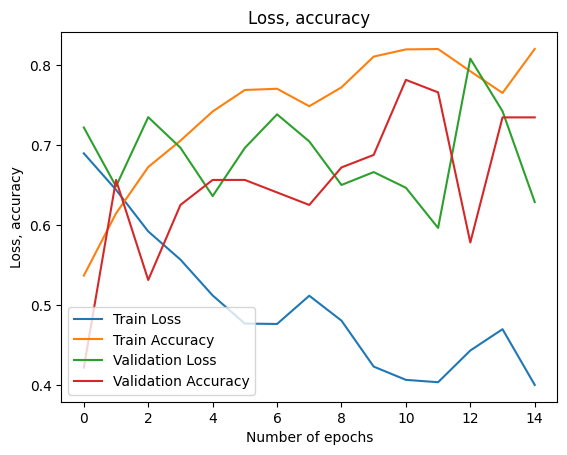

In [76]:
fig1 = plt.figure()
plt.plot(rnn_history.history['loss'], label='Train Loss')
plt.plot(rnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')


plt.legend(loc="best")
plt.title('Loss, accuracy')
plt.ylabel('Loss, accuracy')
plt.xlabel('Number of epochs')
plt.show()   

### Ověření modelu

In [69]:
scores = RNN_model.evaluate(x_test, y_test)
print (f"Loss function: {scores[0]}")
print (f"Accuracy: {scores[1]}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7399 - loss: 0.6094
Loss function: 0.5985209941864014
Accuracy: 0.7436800003051758


Predikce testovacích dat

In [70]:
y_pred = RNN_model.predict(x_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step


Výsledky ohodnocení prvního review

In [71]:
print (f"Odhad: {y_pred[0]}")
print (f"Skutečnost: {y_test[0]}")

Odhad: [0.70640767 0.2935923 ]
Skutečnost: [1. 0.]


Předpovědi a skutečnost

In [78]:
y_pred_best_answer = np.argmax(y_pred, axis=-1)
y_test_best_answer=np.argmax(y_test, axis=-1)
print (f"Předpovědi: {y_pred_best_answer}")
print (f"Skutečnost: {y_test_best_answer}")

Předpovědi: [0 1 0 ... 0 0 1]
Skutečnost: [0 1 1 ... 0 0 0]


Confusion matrix

<Axes: >

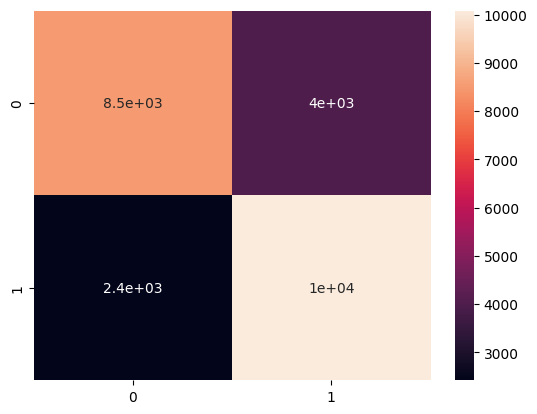

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(y_test_best_answer, y_pred_best_answer)
sns.heatmap(cf_matrix, annot=True)

Přesnost napříč kategoriemi

In [79]:
class_correct, class_count = [0]*10, [0]*10

for i in range(y_test.shape[0]):    
    if (y_test_best_answer[i] == y_pred_best_answer[i]):
        class_correct[y_test_best_answer[i]] +=1
    class_count[y_test_best_answer[i]] += 1
    
for i in range(len(class_names)):
    print (f"Accuracy for {class_names[i]}: {class_correct[i]/class_count[i]:.2%}") 

Accuracy for positive: 68.09%
Accuracy for negative: 80.65%


# GRU model
Model bude velmi podobný, pouze nahradíme SimpleRNN část GRU.

In [86]:
from keras.layers import GRU
gru_model = Sequential(name="GRU_Model")
gru_model.add(Embedding(vocabulary_size,
                        embd_len))
gru_model.add(GRU(128,
                  activation='tanh',
                  return_sequences=False))
gru_model.add(Dense(2, activation='sigmoid'))

Zobrazení struktury sítě

In [87]:
gru_model.summary()

Model: "GRU_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Trénování neuronové GRU sítě

In [88]:
gru_model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

In [89]:
gru_history = gru_model.fit(x_train, y_train,
                         batch_size=64,
                         epochs=15,
                         verbose=1,
                         validation_data=(x_valid, y_valid))

Epoch 1/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 153s 390ms/step - accuracy: 0.5924 - loss: 0.6518 - val_accuracy: 0.8438 - val_loss: 0.3323
Epoch 2/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 178s 456ms/step - accuracy: 0.8543 - loss: 0.3473 - val_accuracy: 0.9062 - val_loss: 0.2413
Epoch 3/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 133s 341ms/step - accuracy: 0.9033 - loss: 0.2540 - val_accuracy: 0.8438 - val_loss: 0.2532
Epoch 4/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 134s 344ms/step - accuracy: 0.9215 - loss: 0.2046 - val_accuracy: 0.9062 - val_loss: 0.2264
Epoch 5/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 138s 353ms/step - accuracy: 0.9339 - loss: 0.1757 - val_accuracy: 0.8906 - val_loss: 0.2295
Epoch 6/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 148s 378ms/step - accuracy: 0.9353 - loss: 0.1687 - val_accuracy: 0.9062 - val_loss: 0.2215
Epoch 7/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 133s 341ms/step - accuracy: 0.9575 - loss: 0.1238 - val_accuracy: 0.9219 - val_loss: 0.2128
Epoch 8/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 142s 365ms/step - accuracy: 0.9680 -

Uložení natrénovaného modelu

In [90]:
gru_model.save('rnn_gru.keras')

### Zobrazení historie učení

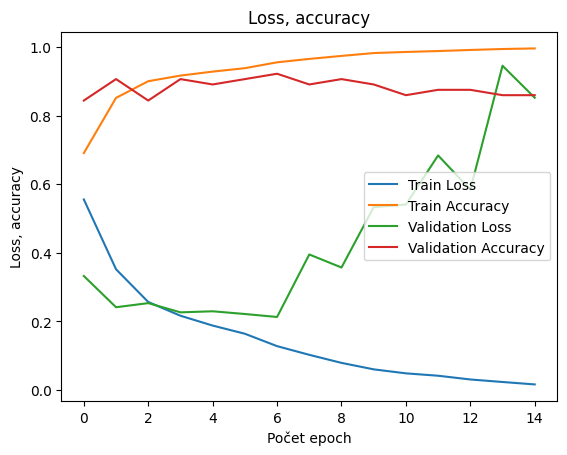

In [91]:
fig2 = plt.figure()                
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['accuracy'], label='Train Accuracy')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.plot(gru_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc="right")
plt.title('Loss, accuracy')
plt.ylabel('Loss, accuracy')
plt.xlabel('Počet epoch')
plt.show()   

### Ověření modelu

In [92]:
scores = gru_model.evaluate(x_test, y_test)
print (f"Loss function: {scores[0]}")
print (f"Accuracy: {scores[1]}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.8661 - loss: 0.7997
Loss function: 0.7692440748214722
Accuracy: 0.8688399791717529


Predikce testovacích dat

In [93]:
y_pred = gru_model.predict(x_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step


Výsledky ohodnocení prvního review

In [94]:
print (f"Odhad: {y_pred[0]}")
print (f"Skutečnost: {y_test[0]}")

Odhad: [9.9999624e-01 4.3295718e-06]
Skutečnost: [1. 0.]


Předpovědi a skutečnost

In [95]:
y_pred_best_answer = np.argmax(y_pred, axis=-1)
y_test_best_answer=np.argmax(y_test, axis=-1)
print (f"Předpovědi: {y_pred_best_answer}")
print (f"Skutečnost: {y_test_best_answer}")

Předpovědi: [0 1 0 ... 0 0 1]
Skutečnost: [0 1 1 ... 0 0 0]


Confusion matrix

<Axes: >

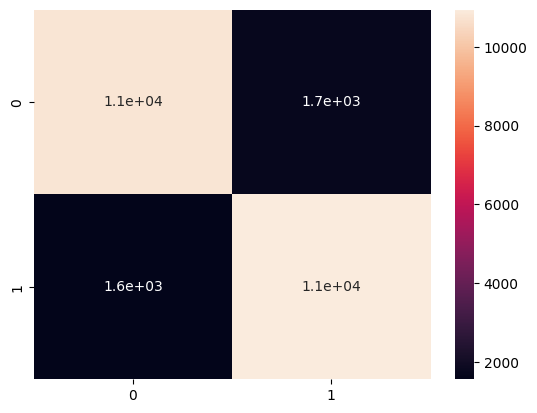

In [96]:
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(y_test_best_answer, y_pred_best_answer)
sns.heatmap(cf_matrix, annot=True)

Přesnost napříč kategoriemi

In [97]:
class_correct, class_count = [0]*10, [0]*10

for i in range(y_test.shape[0]):    
    if (y_test_best_answer[i] == y_pred_best_answer[i]):
        class_correct[y_test_best_answer[i]] +=1
    class_count[y_test_best_answer[i]] += 1
    
for i in range(len(class_names)):
    print (f"Accuracy for {class_names[i]}: {class_correct[i]/class_count[i]:.2%}") 

Accuracy for positive: 86.22%
Accuracy for negative: 87.54%


# LTSM model
Zkusíme LTSM model. Opět vymění jen danou část sítě.

In [98]:
from keras.layers import LSTM

In [103]:
lstm_model = Sequential(name="LSTM_Model")
lstm_model.add(Embedding(vocabulary_size,
                         embd_len))
lstm_model.add(LSTM(128,
                    activation='relu',
                    return_sequences=False))
lstm_model.add(Dense(2, activation='sigmoid'))

Zobrazení struktury sítě

In [104]:
lstm_model.summary()

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Trénování neuronové sítě

In [105]:
lstm_model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

In [106]:
ltsm_history = lstm_model.fit(x_train, y_train,
                          batch_size=64,
                          epochs=15,
                          verbose=1,
                          validation_data=(x_valid, y_valid))

Epoch 1/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 98s 249ms/step - accuracy: 0.5084 - loss: nan - val_accuracy: 0.6094 - val_loss: nan
Epoch 2/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 104s 266ms/step - accuracy: 0.4994 - loss: nan - val_accuracy: 0.6094 - val_loss: nan
Epoch 3/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 98s 251ms/step - accuracy: 0.5003 - loss: nan - val_accuracy: 0.6094 - val_loss: nan
Epoch 4/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 100s 257ms/step - accuracy: 0.4966 - loss: nan - val_accuracy: 0.6094 - val_loss: nan
Epoch 5/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 105s 268ms/step - accuracy: 0.4995 - loss: nan - val_accuracy: 0.6094 - val_loss: nan
Epoch 6/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 102s 261ms/step - accuracy: 0.4987 - loss: nan - val_accuracy: 0.6094 - val_loss: nan
Epoch 7/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 98s 252ms/step - accuracy: 0.5022 - loss: nan - val_accuracy: 0.6094 - val_loss: nan
Epoch 8/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 101s 258ms/step - accuracy: 0.5012 - loss: nan - val_accuracy: 0.6094 - val_loss:

Uložení natrénované sítě

In [107]:
lstm_model.save('rnn_ltsm.keras')

### Zobrazení historie učení

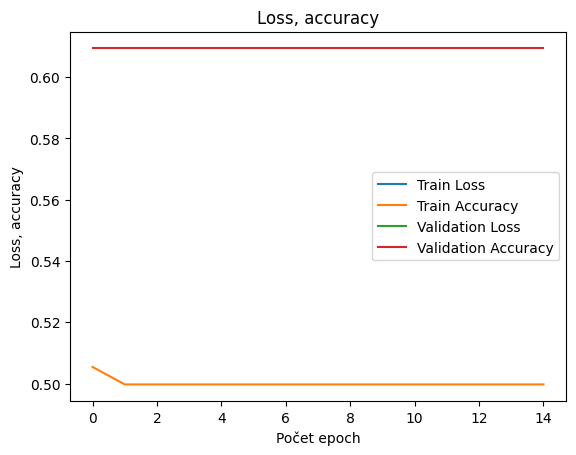

In [108]:
fig3 = plt.figure()                
plt.plot(ltsm_history.history['loss'], label='Train Loss')
plt.plot(ltsm_history.history['accuracy'], label='Train Accuracy')
plt.plot(ltsm_history.history['val_loss'], label='Validation Loss')
plt.plot(ltsm_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc="right")
plt.title('Loss, accuracy')
plt.ylabel('Loss, accuracy')
plt.xlabel('Počet epoch')
plt.show() 

### Ověření modelu

In [109]:
scores = lstm_model.evaluate(x_test, y_test)
print (f"Loss function: {scores[0]}")
print (f"Accuracy: {scores[1]}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step - accuracy: 0.5073 - loss: nan
Loss function: nan
Accuracy: 0.5


Predikce testovacích dat

In [110]:
y_pred = lstm_model.predict(x_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step


Výsledky ohodnocení prvního review

In [111]:
print (f"Odhad: {y_pred[0]}")
print (f"Skutečnost: {y_test[0]}")

Odhad: [nan nan]
Skutečnost: [1. 0.]


Předpovědi a skutečnost

In [115]:
y_pred_best_answer = np.argmax(y_pred, axis=-1)
y_test_best_answer=np.argmax(y_test, axis=-1)
print (f"Předpovědi: {y_pred_best_answer}")
print (f"Skutečnost: {y_test_best_answer}")

Předpovědi: [0 0 0 ... 0 0 0]
Skutečnost: [0 1 1 ... 0 0 0]


Confusion matrix

<Axes: >

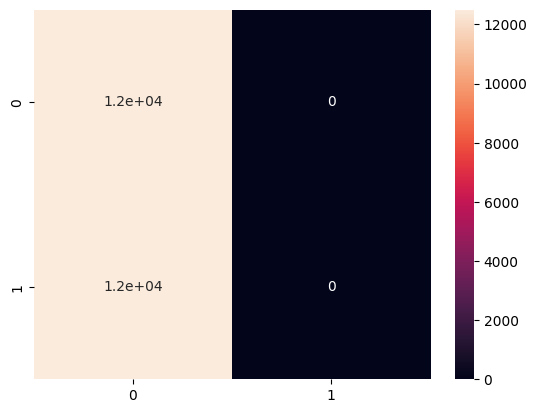

In [116]:
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(y_test_best_answer, y_pred_best_answer)
sns.heatmap(cf_matrix, annot=True)

Přesnost napříč kategoriemi

In [117]:
class_correct, class_count = [0]*10, [0]*10

for i in range(y_test.shape[0]):    
    if (y_test_best_answer[i] == y_pred_best_answer[i]):
        class_correct[y_test_best_answer[i]] +=1
    class_count[y_test_best_answer[i]] += 1
    
for i in range(len(class_names)):
    print (f"Accuracy for {class_names[i]}: {class_correct[i]/class_count[i]:.2%}") 

Accuracy for positive: 100.00%
Accuracy for negative: 0.00%


# Bi-directional LSTM Model
Naposledy vyzkoušíme obousměrný LTSM model

In [118]:
from keras.layers import Bidirectional

In [123]:
bi_lstm_model = Sequential(name="Bidirectional_LSTM")
bi_lstm_model.add(Embedding(vocabulary_size,
                            embd_len))
bi_lstm_model.add(Bidirectional(LSTM(128,
                                     activation='tanh',
                                     return_sequences=False)))
bi_lstm_model.add(Dense(2, activation='sigmoid'))

Vypsání struktury sítě

In [124]:
bi_lstm_model.summary()

Model: "Bidirectional_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Trénování sítě

In [125]:
bi_lstm_model.compile(
  loss="binary_crossentropy",
  optimizer='adam',
  metrics=['accuracy']
)

In [126]:
bi_lstm_history = bi_lstm_model.fit(x_train, y_train,
                             batch_size=64,
                             epochs=15,
                             validation_data=(x_test, y_test))

Epoch 1/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 195s 496ms/step - accuracy: 0.6650 - loss: 0.6015 - val_accuracy: 0.8417 - val_loss: 0.3606
Epoch 2/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 203s 521ms/step - accuracy: 0.8747 - loss: 0.3114 - val_accuracy: 0.8642 - val_loss: 0.3224
Epoch 3/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 198s 508ms/step - accuracy: 0.9004 - loss: 0.2533 - val_accuracy: 0.8621 - val_loss: 0.3237
Epoch 4/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 199s 512ms/step - accuracy: 0.9096 - loss: 0.2341 - val_accuracy: 0.8686 - val_loss: 0.3240
Epoch 5/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 202s 519ms/step - accuracy: 0.9162 - loss: 0.2150 - val_accuracy: 0.8137 - val_loss: 0.5940
Epoch 6/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 205s 525ms/step - accuracy: 0.9193 - loss: 0.2154 - val_accuracy: 0.8535 - val_loss: 0.4032
Epoch 7/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 204s 523ms/step - accuracy: 0.9385 - loss: 0.1668 - val_accuracy: 0.8389 - val_loss: 0.3838
Epoch 8/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 205s 525ms/step - accuracy: 0.9465 -

Uložení natrénovaného modelu

In [127]:
bi_lstm_model.save('rnn_bi_ltsm.keras')

### Zobrazení historie učení

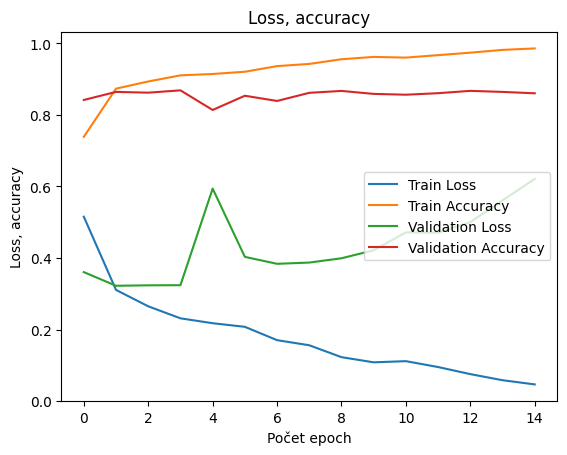

In [128]:
fig4 = plt.figure()                
plt.plot(bi_lstm_history.history['loss'], label='Train Loss')
plt.plot(bi_lstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(bi_lstm_history.history['val_loss'], label='Validation Loss')
plt.plot(bi_lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc="right")
plt.title('Loss, accuracy')
plt.ylabel('Loss, accuracy')
plt.xlabel('Počet epoch')
plt.show() 

### Ověření modelu

In [129]:
scores = bi_lstm_model.evaluate(x_test, y_test)
print (f"Loss function: {scores[0]}")
print (f"Accuracy: {scores[1]}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.8590 - loss: 0.6371
Loss function: 0.6209239959716797
Accuracy: 0.860319972038269


Predikce testovacích dat

In [130]:
y_pred = bi_lstm_model.predict(x_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step


Výsledky ohodnocení prvního review

In [132]:
print (f"Odhad: {y_pred[0]}")
print (f"Skutečnost: {y_test[0]}")

Odhad: [9.9937242e-01 6.2402175e-04]
Skutečnost: [1. 0.]


Předpovědi a skutečnost

In [133]:
y_pred_best_answer = np.argmax(y_pred, axis=-1)
y_test_best_answer=np.argmax(y_test, axis=-1)
print (f"Předpovědi: {y_pred_best_answer}")
print (f"Skutečnost: {y_test_best_answer}")

Předpovědi: [0 1 0 ... 0 1 1]
Skutečnost: [0 1 1 ... 0 0 0]


Confusion matrix

<Axes: >

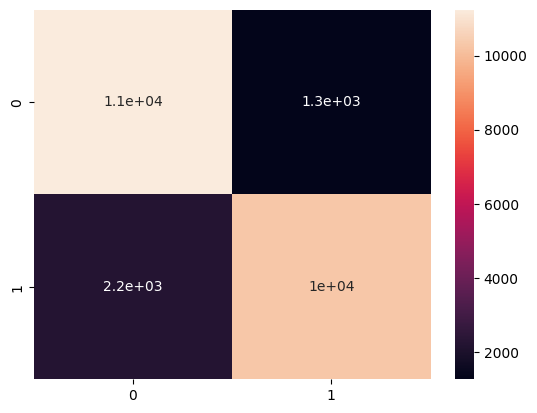

In [134]:
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(y_test_best_answer, y_pred_best_answer)
sns.heatmap(cf_matrix, annot=True)

Přesnost napříč kategoriemi

In [135]:
class_correct, class_count = [0]*10, [0]*10

for i in range(y_test.shape[0]):    
    if (y_test_best_answer[i] == y_pred_best_answer[i]):
        class_correct[y_test_best_answer[i]] +=1
    class_count[y_test_best_answer[i]] += 1
    
for i in range(len(class_names)):
    print (f"Accuracy for {class_names[i]}: {class_correct[i]/class_count[i]:.2%}") 

Accuracy for positive: 89.90%
Accuracy for negative: 82.16%
